# Reproducing "Deep Bayesian Active Learning with Image Data"

Imports

In [ ]:
# PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

# Other
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys

Constants

In [ ]:
T = 20
NUM_CLASSES = 10
EPOCHS = 50
INIT_TRAIN_SIZE = 20
VALID_SIZE = 100
BATCH_SIZE = 128
POOL_BATCH_SIZE = 128
SUBPOOL_SIZE = 10_000
EPSILON = sys.float_info.min
ACQ_SIZE = 10
ACQ_STEPS = 100
REPS = 3
CPU = "cpu"
CUDA = "cuda"
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)
NUM_WORKERS = 2
S_GRID_SEARCH = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
SIGMA_GRID_SEARCH = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]


Load MNIST Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

print(f'\ntrain data size: {len(dataset)}')
print(f'test data size: {len(test_dataset)}')


train data size: 60000
test data size: 10000


Neural Net

In [ ]:
class BCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.phi = nn.Sequential(
            # shape 1,28,28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,25,25
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,22,22
            nn.MaxPool2d(2, 2),
            # shape 32,11,11
            nn.Dropout(p=0.25),
            nn.Flatten(),
            nn.Linear(32*11*11, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )

        self.last_layer = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        phi = self.phi(x)
        return self.last_layer(phi)

    def compute_phi(self, x):
      features = self.phi(x)
      # add bias column
      ones = torch.ones(features.size(0), 1).to(DEVICE)
      return torch.cat([features, ones], dim=1)

In [ ]:
def pretrain_model(train_loader, valid_loader):
  model = BCNN().to(DEVICE)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters())

  for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # convert targets to one-hot encodings
          targets = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

  return model

Analytical Inference

In [ ]:
class AnalyticalInference():
  def __init__(self, s):
    self.s = s # for among-row variance in prior
    self.Sigma = torch.eye(NUM_CLASSES).to(DEVICE) # among-col variance ll/prior
    self.M = None
    self.U = None
    self.V = self.Sigma

  def fit(self, model, loader):
    model.eval()
    all_phi = []
    all_y = []

    with torch.no_grad():
      for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        features = model.compute_phi(images)
        all_phi.append(features)

        y = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float()
        all_y.append(y)

    # (N, 128 + 1) = (N, 129)
    features = torch.cat(all_phi, dim=0)
    # (N, 10)
    targets = torch.cat(all_y, dim=0)

    N, K = features.shape
    Lambda = (self.s ** -2) * torch.eye(K).to(DEVICE)
    PhiTPhi = features.T @ features
    self.U = torch.linalg.inv(PhiTPhi + Lambda)
    self.M = self.U @ features.T @ targets

  def predict(self, model, loader):
    '''
    features: (N,K)
    mu_star: (N,D)
    var_star: (N, D, D)
    '''

    model.eval()
    sq_errs = 0.0
    num_preds = 0
    all_covars = []

    with torch.no_grad():
      for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        features = model.compute_phi(images)

        N, K = features.shape

        # different to notes (N, K) @ (K, D) = (N, D)
        mu_star = features @ self.M

        # compute phi.T U phi for each sample
        # efficiently compute diagonal
        phi_U = features @ self.U
        scalar = 1 + (phi_U * features).sum(dim=1) #(N)

        # (N, 1, 1) * (D, D) = (N, D, D)
        covar_star = scalar.view(N, 1, 1) * self.Sigma.unsqueeze(0)

        # store results
        all_covars.append(covar_star)

        # test
        y = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float()
        errors = y - mu_star
        sq_errs += errors.pow(2).sum().item()
        num_preds += y.numel()

    all_covars = torch.cat(all_covars, dim=0)
    rmse = np.sqrt(sq_errs/num_preds)
    return all_covars, rmse

Analytical MFVI

In [ ]:
class MFVIInference():
  def __init__(self, s, sigma):
    self.s = s # for among-row variance in prior
    self.sigma = sigma # among-col variance ll/prior
    self.M = None
    self.S = None

  def fit(self, model, loader):
    model.eval()
    all_phi = []
    all_y = []

    with torch.no_grad():
      for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        features = model.compute_phi(images)
        all_phi.append(features)

        y = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float()
        all_y.append(y)

    # (N, 128 + 1) = (N, 129)
    features = torch.cat(all_phi, dim=0)
    # (N, 10)
    targets = torch.cat(all_y, dim=0)

    N, K = features.shape

    # M
    PhiTPhi = features.T @ features
    PhiTY = features.T @ targets
    B = (self.sigma ** 2)/(self.s ** 2) * torch.eye(K).to(DEVICE)
    A = PhiTPhi + B
    self.M = torch.linalg.solve(A, PhiTY)

    # S: (K) as same across D
    sum_phi2 = (features ** 2).sum(dim=0) #(K)
    self.S = 1.0 / ((self.s**-2)+(self.sigma**-2)*sum_phi2)

  def predict(self, model, loader):
    '''
    features: (N,K)
    mu_star: (N,D)
    var_star: (N, D, D)
    '''

    model.eval()
    sq_errs = 0.0
    num_preds = 0
    all_covars = []

    with torch.no_grad():
      for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        features = model.compute_phi(images)

        N, K = features.shape

        # different to notes (N, K) @ (K, D) = (N, D)
        mu_star = features @ self.M

        # shared across D
        # we assumed S is diagonal
        epistemic = (features ** 2) @ self.S
        covar_star = (self.sigma**2) + epistemic
        # resize to be consistent with analytical inference
        covar_star = covar_star.unsqueeze(1).expand(-1, NUM_CLASSES) #(N,D)
        covar_star = torch.diag_embed(covar_star) #(N,D,D)

        # store covars
        all_covars.append(covar_star)

        # test
        y = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).float()
        errors = y - mu_star
        sq_errs += errors.pow(2).sum().item()
        num_preds += y.numel()

    all_covars = torch.cat(all_covars, dim=0)
    rmse = np.sqrt(sq_errs/num_preds)
    return all_covars, rmse


Temp Testing

Active Learning

In [ ]:
def predictive_variance(model, inf_layer, pool_loader):
  # batch diagonal then sum over last dimension (batch size)
  covars, _ = inf_layer.predict(model, pool_loader)
  scores = covars.diagonal(dim1=-2, dim2=-1).sum(dim=-1)

  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def baseline(model, pool_loader, mc):
  pool_size = len(pool_loader.dataset)
  top_scores = torch.zeros(pool_size)
  top_indices = torch.randperm(pool_size)[:ACQ_SIZE]

  return top_scores, top_indices

Experiments  

In [ ]:
def exp2():
  results = []

  # set up initial random but balanced training set
  gen = torch.Generator().manual_seed(42)
  N = len(dataset)
  pool_size = N - VALID_SIZE

  train_indices = []
  targets = dataset.targets
  for c in range(NUM_CLASSES):
    indices = (targets == c).nonzero(as_tuple=True)[0]
    shuffled = indices[torch.randperm(len(indices), generator=gen)]
    train_indices.extend(shuffled.tolist()[:(INIT_TRAIN_SIZE//10)])

  remaining_indices = list(set(range(N)) - set(train_indices))
  remaining_indices = torch.tensor(remaining_indices)[
      torch.randperm(len(remaining_indices), generator=gen)
  ]

  valid_indices = remaining_indices[:VALID_SIZE].tolist()
  pool_indices = remaining_indices[VALID_SIZE:].tolist()

  train_subset = Subset(dataset, train_indices)
  valid_subset = Subset(dataset, valid_indices)

  train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
  valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  # pre train model
  bcnn = None
  inf_layer = None
  best_rmse = sys.maxsize
  s = None
  for param in S_GRID_SEARCH:
    c_bcnn = pretrain_model(train_loader, valid_loader)
    c_inf_layer = AnalyticalInference(param)
    c_inf_layer.fit(c_bcnn, train_loader)
    covars, rmse = c_inf_layer.predict(c_bcnn, valid_loader)
    # print(f"s={param}, Validation RMSE={rmse}")
    if rmse < best_rmse:
      best_rmse = rmse
      bcnn = c_bcnn
      inf_layer = c_inf_layer
      s = param

  print(f"Trained Initial Model, s={s}, Validation RMSE={rmse}")

  # test initial model
  _, test_rmse = inf_layer.predict(bcnn, test_loader)
  print(f'Initial Test RMSE: {test_rmse}')
  results.append(float(test_rmse))

  # active learning
  pbar = tqdm.trange(ACQ_STEPS)
  pbar.set_description("Active Learning")
  pbar_postfix = {}

  for i in pbar:
    pbar_postfix["Status"] = "Running Acq Func"
    pbar.set_postfix(pbar_postfix)

    # use random data points from pool set
    pool_size = len(pool_indices)
    subpool_size = min(pool_size, SUBPOOL_SIZE)
    rand_subpool_idxs = torch.randperm(pool_size)[:subpool_size]
    subpool_idxs = torch.tensor(pool_indices)[rand_subpool_idxs].tolist()
    subpool_subset = Subset(dataset, subpool_idxs)
    subpool_loader = DataLoader(subpool_subset, batch_size=POOL_BATCH_SIZE, shuffle=False, pin_memory=True)

    # score using acquisition function
    top_scores, top_indices = predictive_variance(bcnn, inf_layer, subpool_loader)

    # update pool and training data
    acq_tensor = torch.tensor(subpool_idxs)[top_indices.to(CPU)]
    acq_list = acq_tensor.tolist()
    train_indices.extend(acq_list)
    pool_indices = list(set(pool_indices) - set(acq_list))

    train_subset = Subset(dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

    # train model
    pbar_postfix["Status"] = "Training Model"
    pbar.set_postfix(pbar_postfix)

    inf_layer = AnalyticalInference(s)
    inf_layer.fit(bcnn, train_loader)

    # test model
    pbar_postfix["Status"] = "Testing Model"
    pbar.set_postfix(pbar_postfix)

    _, test_rmse = inf_layer.predict(bcnn, test_loader)
    results.append(float(test_rmse))

    pbar_postfix["Acq Step"] = f"{i+1}"
    pbar_postfix["Test RMSE"] = f"{test_rmse}"
    pbar.set_postfix(pbar_postfix)

  return results

Main

In [ ]:
# run experiment
trials = []
for _ in range(REPS):
  results = exp2()
  trials.append(results)

print("\n")
print(trials)

Trained Initial Model, s=1.0, Validation RMSE=0.26577008043934947
Initial Test RMSE: 0.2512457405412507


Active Learning: 100%|██████████| 100/100 [06:49<00:00,  4.10s/it, Status=Testing Model, Acq Step=100, Test RMSE=0.22268998506601043]


Trained Initial Model, s=10.0, Validation RMSE=0.2582322429449636
Initial Test RMSE: 0.25110021447795794


Active Learning: 100%|██████████| 100/100 [06:50<00:00,  4.11s/it, Status=Testing Model, Acq Step=100, Test RMSE=0.21587306053469923]


Trained Initial Model, s=10.0, Validation RMSE=0.25748909936442727
Initial Test RMSE: 0.2519171464174956


Active Learning: 100%|██████████| 100/100 [06:50<00:00,  4.11s/it, Status=Testing Model, Acq Step=100, Test RMSE=0.21628698762542967]



[[0.2512457405412507, 0.2509806051512021, 0.24958107650407288, 0.2479429150531651, 0.24475839962052212, 0.2437023972025146, 0.24349304997279808, 0.24038770880307994, 0.23949783862578156, 0.2377612081547265, 0.23761919419662436, 0.23643390354100463, 0.23671545625415816, 0.23463719853194903, 0.2350134282029422, 0.2346286817209968, 0.23507280567219704, 0.2337644928911852, 0.2299164279781189, 0.22992060240413775, 0.22905354414394008, 0.22809001238345458, 0.2279119877889988, 0.22772227673595716, 0.2275837936769195, 0.22733482719818043, 0.22651680569480162, 0.22620067530867655, 0.2270877274837626, 0.22771117109907804, 0.22800197216486018, 0.22812863628676974, 0.22767091352775368, 0.22757699485155095, 0.2277693827867936, 0.22804418558989803, 0.22738057898607508, 0.22805715790605274, 0.22810153156955396, 0.22832107332362278, 0.22817756586488927, 0.2275544696198735, 0.22763197688429737, 0.22740258715658407, 0.2269577775750786, 0.22703115309144148, 0.22650266750188072, 0.22627813908219563, 0.2

Plot

In [ ]:
# data: list of {"data": [], "label": str, "color": str}
def plot_graph(data, std=False):
  x = [i*ACQ_SIZE for i in range(ACQ_STEPS+1)]

  for line in data:
    y = np.mean(line["data"], axis=0)
    plt.plot(x,y, label=line["label"], color=line["color"])
    if std:
      y_std = np.std(line["data"], axis=0)
      plt.fill_between(x, y - y_std, y + y_std, color=line["color"], alpha=0.2)

  plt.ylim(0.20, 0.30)
  plt.xticks(np.arange(0, 1100, 100))

  plt.legend(loc='lower right')
  plt.grid(linestyle='--')
  plt.show()

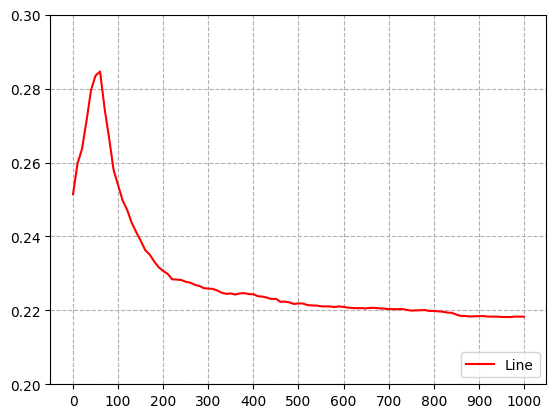

In [ ]:
plot_data = [
    {"data": trials, "label": "Line", "color": "red"},
]

plot_graph(plot_data, std=False)